# Project 6: What Drives Movie Ratings?

# Overview

**Objective ** 

-------------------

This study aims to identify what fields influence positive movie ratings on IMDB.

**Summary of Final Fields ** 

-------------------


Number of Votes, Year, Review Sentiment Ratio, Review Keywords, Review Trigrams

**Study Outline**

-------------------

* *Initial Setup*
    * IMDB API, etc


* *Data Collection & Mining*
    * Movies table
    * Reviews table
    * Sentiment scoring
    * Keywords and trigrams
    * SQL Join - emphasis 'for practice'


* *Modelling*
    * Import data
    * Reduce noise
    * Initialize models
    * Run models
    * Select features and preform GridSearchCV
    * Validate models

# Initial Setup

In [1]:
import os
import subprocess
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import scipy
import requests

#from imdbpie import Imdb
import imdb

import nltk
import matplotlib.pyplot as plt
import urllib
from bs4 import BeautifulSoup
import nltk
import collections
import re
import csv
%matplotlib inline

import sys
reload(sys)
sys.setdefaultencoding('utf-8')

import sqlalchemy
from sqlalchemy import create_engine
import psycopg2
engine = create_engine("postgresql://allenbyron:@localhost/imdb")

Initially I attempted to conda install imdbpie. That was unsuccessful (albeit I could pip install), so I attempted to use the IMDbPY library as an alternative, but the get_top250_movies() function does not work as others have pointed out: http://stackoverflow.com/questions/29869472/imdbpy-get-top250-movies-returns-empty-list. As a final resort, I decided to run imdbpie in my terminal to create the CSV's I would need for this project, which is why there are several points below where I have imported from CSVs.

# Data Collection & Mining

In [2]:
#search_imdb = imdb.IMDbBase()
#top250 = search_imdb.get_top250_movies()

##### Generate and explore movies table

In [3]:
movies = pd.read_csv('./imdb_top250.csv', index_col=0)
movies.head()

,can_rate,image,num_votes,rating,tconst,title,type,year
0,True,{u'url': u'https://images-na.ssl-images-amazon...,1718414,9.3,tt0111161,The Shawshank Redemption,feature,1994
1,True,{u'url': u'https://images-na.ssl-images-amazon...,1174533,9.2,tt0068646,The Godfather,feature,1972
2,True,{u'url': u'https://images-na.ssl-images-amazon...,804896,9.0,tt0071562,The Godfather: Part II,feature,1974
3,True,{u'url': u'https://images-na.ssl-images-amazon...,1704604,9.0,tt0468569,The Dark Knight,feature,2008
4,True,{u'url': u'https://images-na.ssl-images-amazon...,457555,8.9,tt0050083,12 Angry Men,feature,1957


In [4]:
print movies.can_rate.unique()
print
print movies.num_votes.unique()
print
print movies.rating.unique()
print
print movies['type'].unique()
print
print movies.year.unique()
print

In [5]:
movies.drop(labels=['image','can_rate','type'], axis=1, inplace=True)

In [6]:
movies.info()

In [7]:
print 'Rating Median: ', movies.rating.median()
movies.describe()

,num_votes,rating,year
count,2.500000e+02,250.000000,250.00000
mean,4.134674e+05,8.310000,1984.03600
std,3.398039e+05,0.232716,24.25953
min,2.629300e+04,8.000000,1921.00000
25%,1.220845e+05,8.100000,1964.25000
50%,3.310745e+05,8.300000,1991.00000
75%,6.079975e+05,8.400000,2003.75000
max,1.718414e+06,9.300000,2016.00000


Uploaded to SQL to join with the next table (NOTE: I'm doing this as a matter of exercise and proof that I can work with PostgreSQL. In practice, I would approach sharing tables on a case-by-case basis )

In [8]:
#Below commented out as table has already been created 
#movies.to_sql('top250movies', engine)

##### Review and explore 'reviews' table

In [9]:
movies.tconst.to_csv('./list_of_tconst.csv')

In [10]:
reviews = pd.read_csv('./reviews_df.csv', index_col=0)

Remove numbers from reviews and transform to lowercase.

In [11]:
from nltk.tokenize import sent_tokenize, word_tokenize

reviews_nonums=[]

def find_words(col):
    
    for rev in col:
        words = word_tokenize(rev)        
        new_review=''
        for w in words:
            keep = re.search('^[a-zA-Z]+', w)
            if keep is not None:
                new_review+= w + ' '
        reviews_nonums.append(new_review.lower())

In [12]:
find_words(reviews.reviews)

In [13]:
reviews['reviews_nonums'] = reviews_nonums

##### Analyse sentiment and identify words associated with reviews that generate the highest sentiment.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
tfidf = TfidfVectorizer(use_idf=True)
words_array = tfidf.fit_transform(reviews.reviews_nonums)
feature_names = tfidf.get_feature_names()
words_array.shape

(250, 11607)

In [16]:
from nltk.corpus import sentiwordnet

sentiment = []

for rev in reviews.reviews_nonums:

    senti_score = 0
    
    for word in nltk.word_tokenize(rev):
        
        try:
            pos = sentiwordnet.senti_synsets(word)[0].pos_score()
            senti_score += pos
        except:
            senti_score += 0
        
        try:
            neg = sentiwordnet.senti_synsets(word)[0].neg_score()
            senti_score -= neg
        except:
            senti_score += 0
                    
    sentiment.append(senti_score)

In [17]:
def find_length(x):
    return len(x)

In [18]:
reviews['reviews_nonums_length'] = reviews.reviews_nonums.apply(find_length)
reviews['review_sent'] = sentiment
reviews['review_sent_ratio'] = reviews.review_sent/reviews.reviews_nonums_length
reviews.head()

,tconst,reviews,reviews_nonums,reviews_nonums_length,review_sent,review_sent_ratio
0,tt0111161,Why do I want to write the 234th comment on Th...,why do i want to write the comment on the shaw...,1657,4.125,0.002489
1,tt0068646,Rather than concentrating on everything that i...,rather than concentrating on everything that i...,1291,8.500,0.006584
2,tt0071562,\nThis movie is way to be good to be labelled ...,this movie is way to be good to be labelled a ...,816,3.237,0.003967
3,tt0468569,We've been subjected to enormous amounts of hy...,we been subjected to enormous amounts of hype ...,1706,5.625,0.003297
4,tt0050083,\nAn excellent courtroom drama with a unique t...,an excellent courtroom drama with a unique twi...,4985,9.250,0.001856


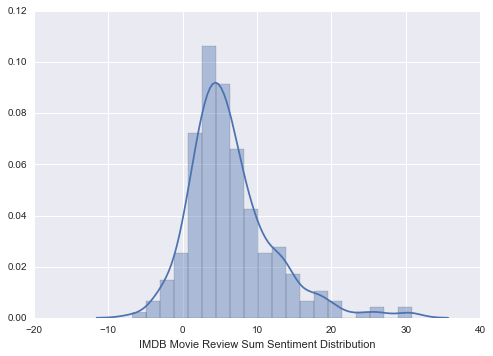

In [19]:
import seaborn as sb
sb.distplot(sentiment, axlabel='IMDB Movie Review Sum Sentiment Distribution')
plt.show()

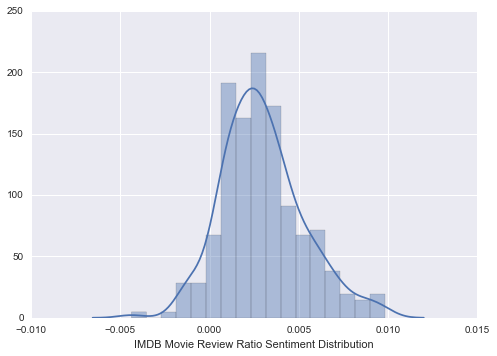

In [20]:
sb.distplot(reviews.review_sent_ratio, axlabel='IMDB Movie Review Ratio Sentiment Distribution')
plt.show()

In [21]:
from sklearn.linear_model import ElasticNetCV
elastic = ElasticNetCV()
elastic.fit(words_array,reviews.review_sent_ratio)

coef_feature_word_df = pd.DataFrame()
coef_feature_word_df['feature_words'] = feature_names
coef_feature_word_df['elasticnet_coef'] = elastic.coef_ 

coef_feature_word_df.elasticnet_coef.max()

0.014864690711841237

In [22]:
coef_feature_word_df.sort_values(by='elasticnet_coef', axis=0, ascending=False).head(20)

,feature_words,elasticnet_coef
820,beautiful,0.014865
865,believable,0.014244
4359,gentleman,0.012794
3846,favorite,0.011964
539,art,0.011513
11083,very,0.009708
9676,sport,0.009690
2672,depth,0.009585
5550,is,0.009451
10252,tears,0.009412


##### Create a count vectorization-like set of columns to the reviews table for the top sentiment words

In [23]:
top20words = coef_feature_word_df.sort_values(by='elasticnet_coef', axis=0, ascending=False).head(10)
top20words = list(top20words.feature_words)
top20words = [str(x) for x in top20words]
top_sent_words = ['beautiful',
                'believable',
                'gentleman',
                'favorite',
                'art' #,
                #'very',
                #'sport',
                #'depth',
                #'tears',
                #'love'
                 ]

In [24]:
def find_top_words(col, alist):
    for word in alist:
        anewlist=[]
        for rev in col:
            if word in rev:
                anewlist.append(1)
            else:
                anewlist.append(0)
                
        reviews[word] = anewlist

In [25]:
find_top_words(reviews.reviews_nonums, top_sent_words) 

##### Find most influential bigrams

In [26]:
tfidf_phrase = TfidfVectorizer(ngram_range=(2,2))

phrase_array = tfidf_phrase.fit_transform(reviews.reviews_nonums)
feature_phrases = tfidf_phrase.get_feature_names()

elastic = ElasticNetCV()
elastic.fit(phrase_array,reviews.review_sent_ratio)

coef_feature_word_df = pd.DataFrame()
coef_feature_word_df['feature_words'] = feature_phrases
coef_feature_word_df['elasticnet_coef'] = elastic.coef_ 

coef_feature_word_df.elasticnet_coef.max()

0.01004459405846833

In [27]:
coef_feature_word_df.sort_values(by='elasticnet_coef', axis=0, ascending=False).head(20)

,feature_words,elasticnet_coef
28172,is just,0.010045
55172,this movie,0.005495
0,1960ish there,0.000000
42517,probing revelation,-0.000000
42505,probably redundant,-0.000000
42506,probably remind,0.000000
42507,probably scorsese,0.000000
42508,probably scribbled,-0.000000
42509,probably seem,-0.000000
42510,probably should,-0.000000


##### Find most influential trigrams

In [28]:
tfidf_phrase = TfidfVectorizer(ngram_range=(3,3))

phrase_array = tfidf_phrase.fit_transform(reviews.reviews_nonums)
feature_phrases = tfidf_phrase.get_feature_names()
words_array.shape

(250, 11607)

In [29]:
from sklearn.linear_model import ElasticNetCV
elastic = ElasticNetCV()
elastic.fit(phrase_array,reviews.review_sent_ratio)

coef_feature_word_df = pd.DataFrame()
coef_feature_word_df['feature_words'] = feature_phrases
coef_feature_word_df['elasticnet_coef'] = elastic.coef_ 

coef_feature_word_df.elasticnet_coef.max()

0.050360441321364184

In [30]:
coef_feature_word_df.sort_values(by='elasticnet_coef', axis=0, ascending=False).head(20)

,feature_words,elasticnet_coef
42826,it is truly,0.050360
82634,this movie is,0.026620
77406,the green mile,0.025667
75368,the acting is,0.019731
59717,out of ten,0.017749
5859,and the fact,0.017276
40893,is just so,0.016728
95916,you have to,0.015868
5818,and the beast,0.015300
71062,sport it shows,0.014947


##### Create a count vectorization-like set of columns to the reviews table for the top sentiment trigrams
Strong coeffecients amongs the trigrams indicate a relatively strong impact on sentiment and possiblly ratings. Conversely, the bigrams had particularly low coeffecients, which is why I am not including them in the final table.

In [31]:
top_trigrams = coef_feature_word_df.sort_values(by='elasticnet_coef', axis=0, ascending=False).head(10)
top_trigrams = list(top_trigrams.feature_words)
top_trigrams = [str(x) for x in top_trigrams]
top_trigrams = ['it is truly',
                 'this movie is',
                 'the green mile',
                 'the acting is',
                 'out of ten' #,
                 #'and the fact',
                 #'is just so',
                 #'you have to',
                 #'and the beast',
                 #'sport it shows'
               ]

In [32]:
find_top_words(reviews.reviews_nonums, top_trigrams) 

In [33]:
#Below commented out as table has already been created 
#reviews.to_sql('reviews', engine)

# Modelling

##### Import data

In [134]:
movie_revs = pd.read_sql_query('select * from top250movies m inner join reviews r on m.tconst = r.tconst;', con=engine, index_col='tconst')

In [135]:
drop_columns = ['index','reviews','reviews_nonums','review_sent','reviews_nonums_length', 'title']
movie_revs.drop(labels=drop_columns, axis=1, inplace=True)

##### Identify and reduce noise in the dataset

Year and Number of Votes appear to be noisy and bimodal, so I will segment these two fields to focus on movies after 1970 and those that recieved 250,000+ votes. This should reduce noise and help us focus on the most recent movies and relevant data points. 

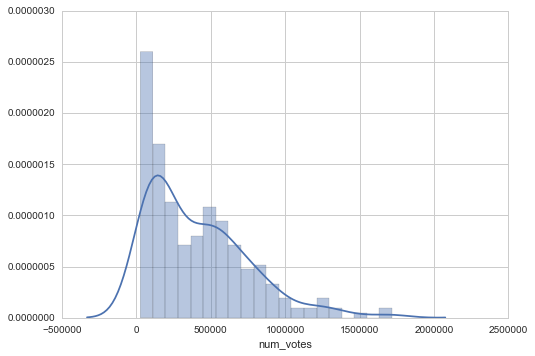

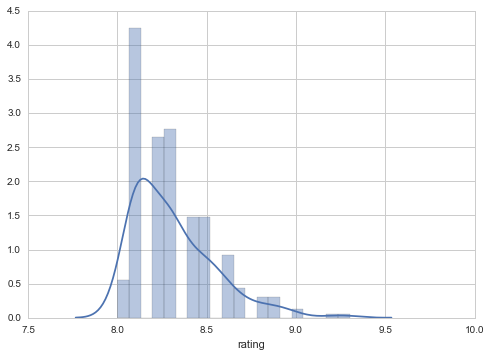

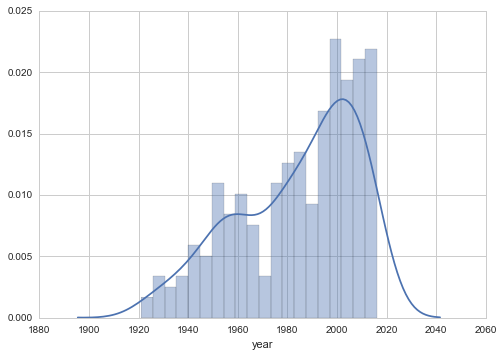

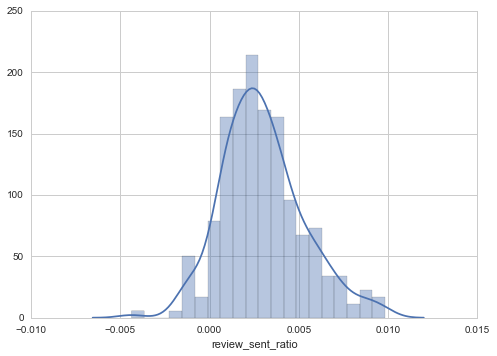

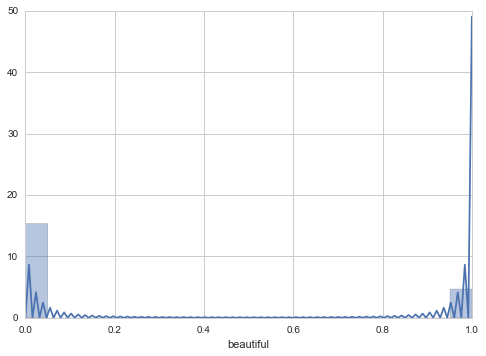

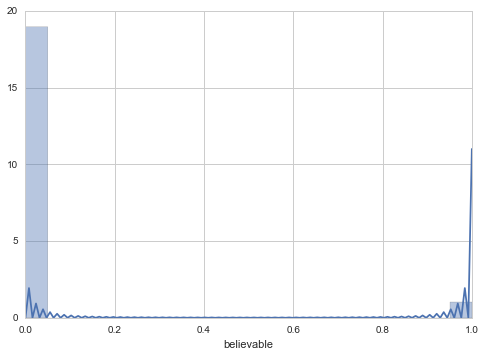

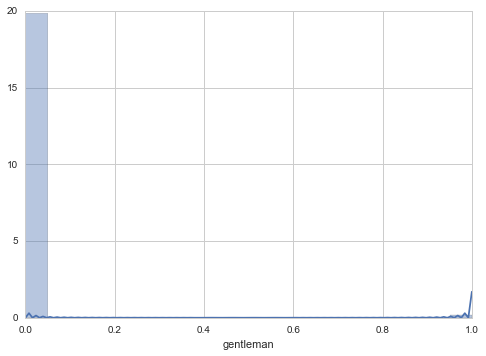

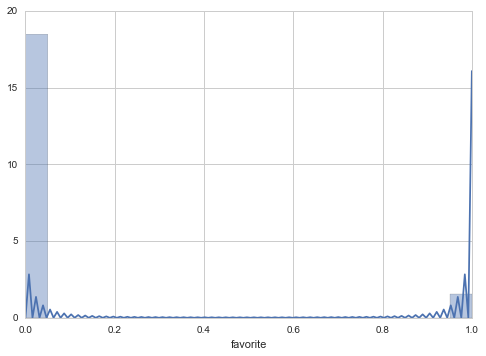

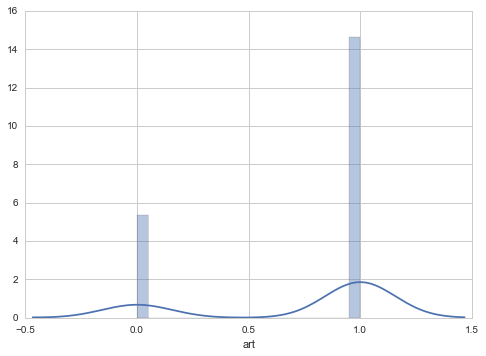

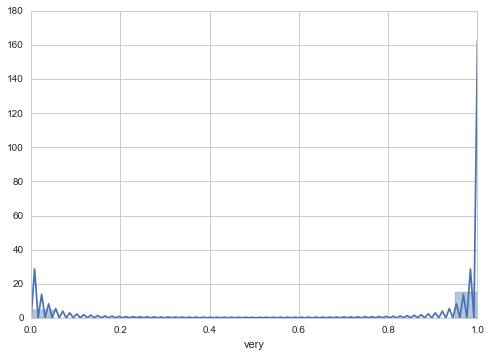

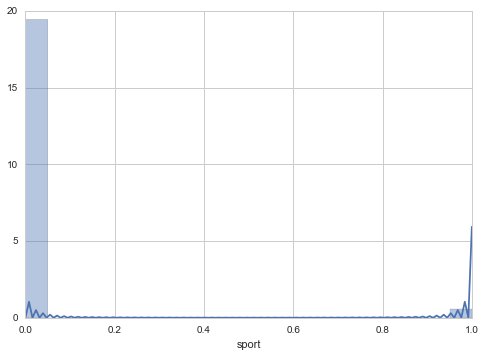

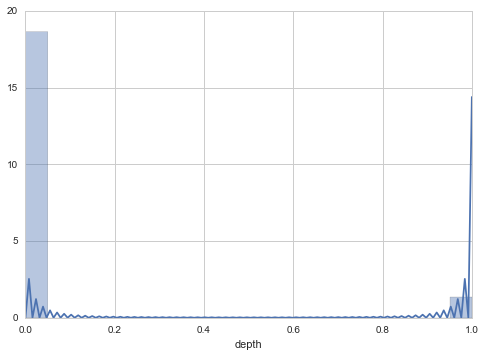

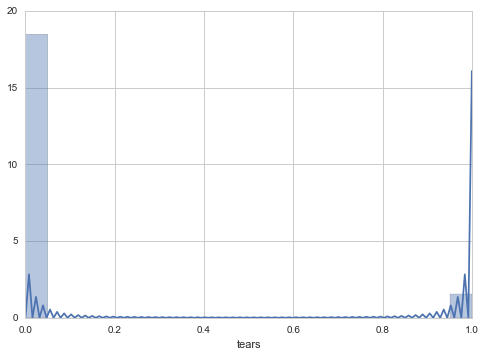

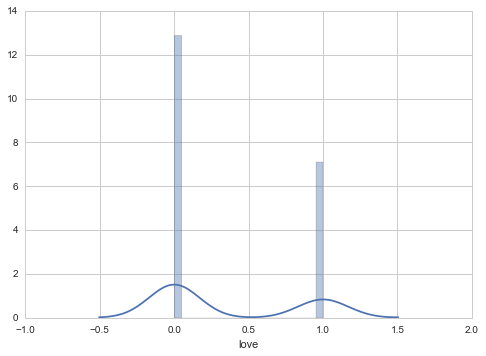

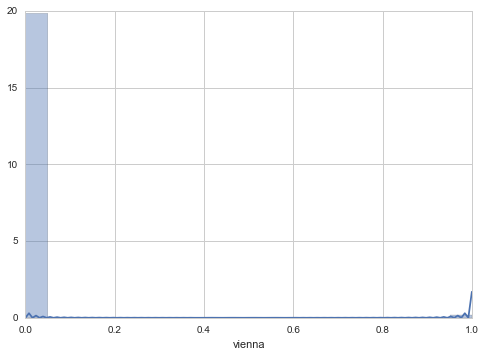

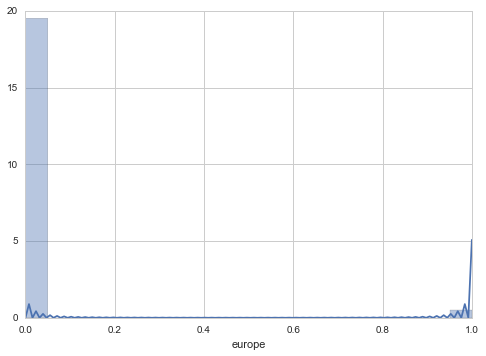

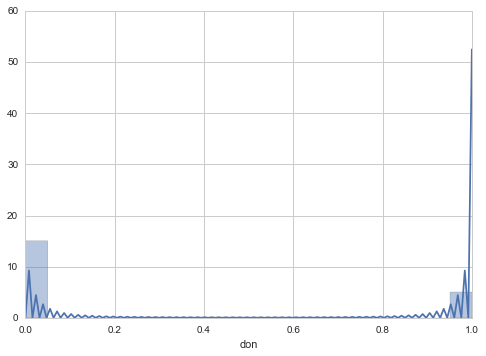

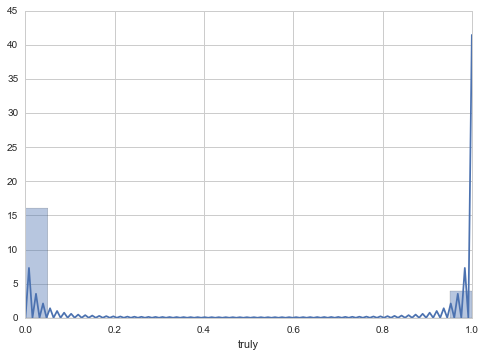

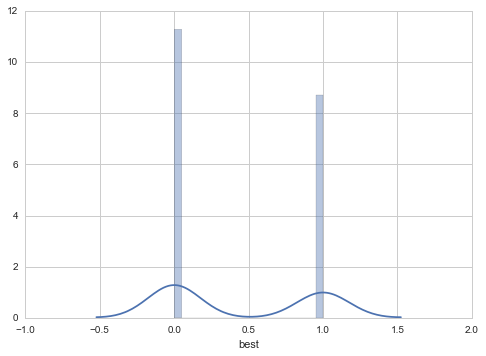

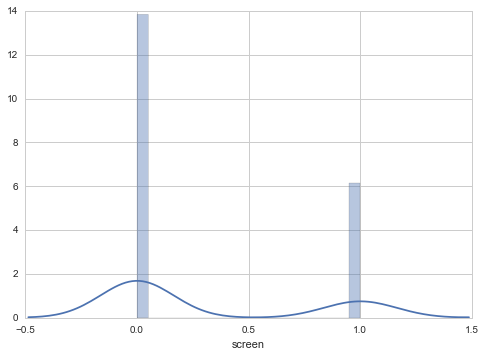

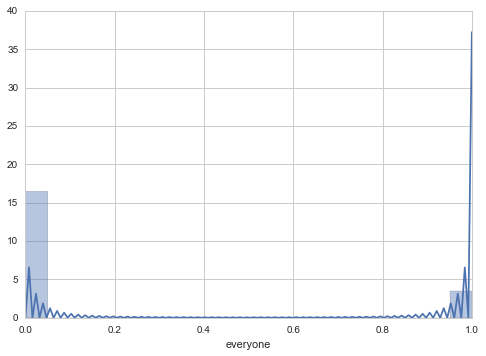

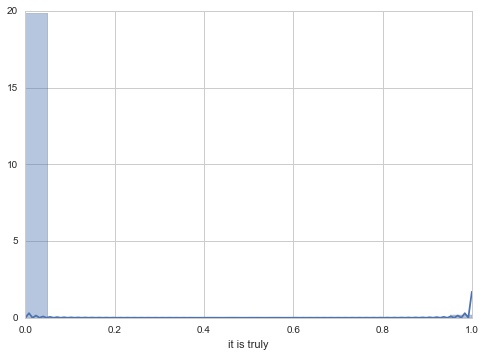

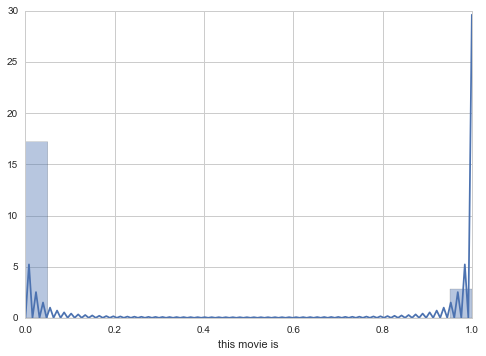

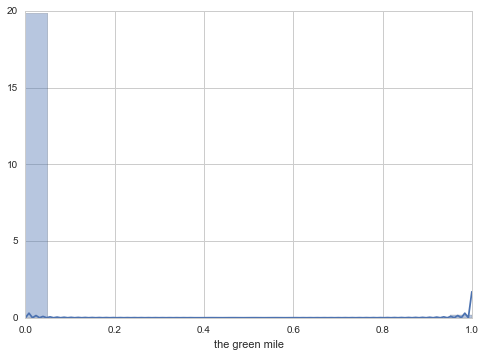

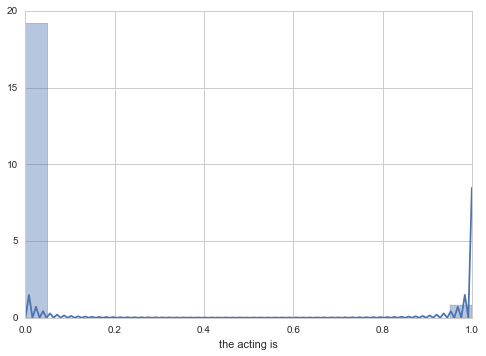

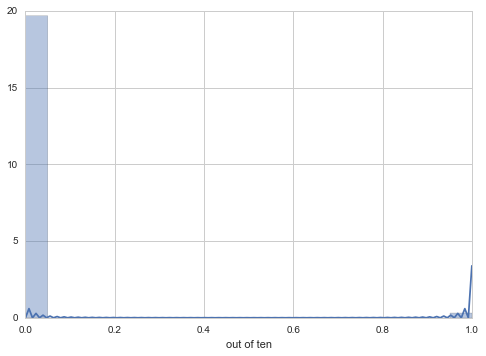

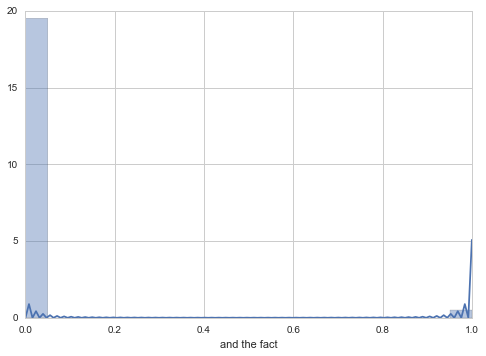

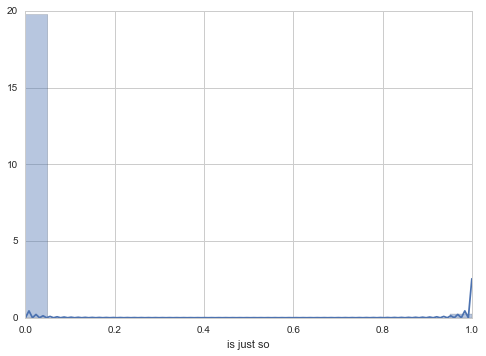

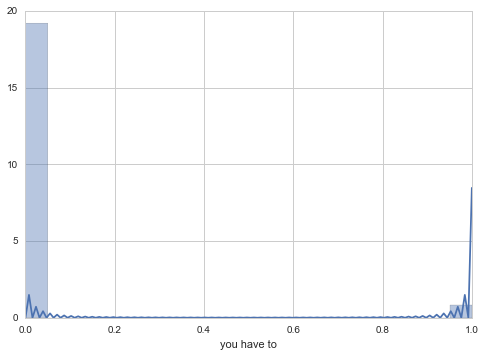

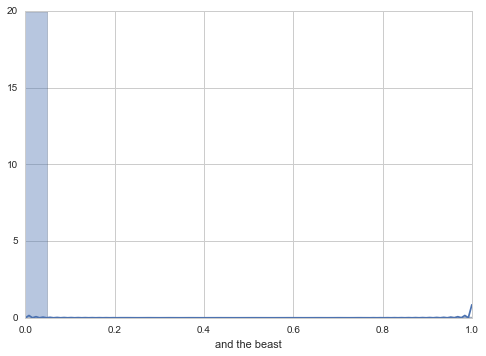

In [136]:
for i in range(30):
    sb.distplot(movie_revs[[str(x) for x in list(movie_revs.columns)][i]], bins=20)
    plt.show()

In [137]:
movie_revs.num_votes = np.where(movie_revs.num_votes >= 250000, 1, 0)
movie_revs.year = np.where(movie_revs.num_votes >= 250000, 1, 0)

##### Initialize models

In [2]:
from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, ElasticNet
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn.cross_validation import cross_val_score

In [3]:
elastic=ElasticNet()
bag_elastic=BaggingRegressor(base_estimator=elastic, random_state=42)
dtree=DecisionTreeRegressor(random_state=42)
bag_dtree=BaggingRegressor(base_estimator=dtree, random_state=42)
extree=ExtraTreeRegressor(random_state=42)
bag_extree=BaggingRegressor(base_estimator=extree,random_state=42)
rforest=RandomForestRegressor(random_state=42)
bag_rforest=BaggingRegressor(base_estimator=rforest,random_state=42)
adaboost=AdaBoostRegressor(random_state=42)
bag_adaboost=BaggingRegressor(base_estimator=adaboost, random_state=42)
knn_k2=KNeighborsRegressor(n_neighbors=2)
bag_knn_k2=BaggingRegressor(base_estimator=knn_k2, random_state=42)
knn_k3=KNeighborsRegressor(n_neighbors=3)
bag_knn_k3=BaggingRegressor(base_estimator=knn_k3, random_state=42)
knn_k4=KNeighborsRegressor(n_neighbors=4)
knn_k5=KNeighborsRegressor(n_neighbors=5)
bag_knn_k5=BaggingRegressor(base_estimator=knn_k5, random_state=42)
knn_k6=KNeighborsRegressor(n_neighbors=6)
dumm=DummyRegressor()

In [140]:
def RegressorMSEScore(model, X, y, columns):
    
    #Returns a list of results 
    results = []

    scoring = cross_val_score(model,X,y,cv=5,scoring='mean_squared_error')
    
    score = scoring.mean()*-1
    results.append(score)
    
    score_std = scoring.std()
    results.append(score_std)
    
    model.fit(X,y)
    
    closed = False
    
    try:
        feature_scores = model.coef_.tolist()
        closed = True
    except:
        pass    
    
    if closed == False:
        try:
            feature_scores = model.estimator_.coef_.tolist()
            closed = True
        except:
            pass
    
    if closed == False:
        try:    
            feature_scores = model.feature_importances_ 
        except:
            feature_scores = ['None'] * len(columns)

    for score in feature_scores:
        results.append(score) 
    
    return results

##### Set variables and run models

In [141]:
from sklearn.preprocessing import StandardScaler, RobustScaler

Stage 1: Initial Model Test

In [142]:
#Original X
X_original = movie_revs.drop(labels=['rating'], axis=1)
columns = X_original.columns

#Scalled X
scaler = StandardScaler()
X_scalled = scaler.fit_transform(X_original)

#Select the X and y
X = X_scalled
y = movie_revs.rating


list_of_models = [elastic,
                  bag_elastic,
                  dtree,
                  bag_dtree,
                  extree,
                  bag_extree,
                  rforest,
                  bag_rforest,
                  adaboost,
                  bag_adaboost,
                  knn_k2,
                  bag_knn_k2,
                  knn_k3,
                  bag_knn_k3,
                  knn_k4,
                  knn_k5,
                  bag_knn_k5,
                  knn_k6,
                  dumm]


list_of_models_str = ['elastic',
                      'bag_elastic',
                      'dtree',
                      'bag_dtree',
                      'extree',
                      'bag_extree',
                      'rforest',
                      'bag_rforest',
                      'adaboost',
                      'bag_adaboost',
                      'knn_k2',
                      'bag_knn_k2',
                      'knn_k3',
                      'bag_knn_k3',
                      'knn_k4',
                      'knn_k5',
                      'bag_knn_k5',
                      'knn_k6',
                      'dumm']

#Build index
index=[]
index.append('score')
index.append('score_std')
for x in columns:
    index.append(x) 

#Build dataframe
scoring_df = pd.DataFrame(index=index)
zipped = zip(list_of_models,list_of_models_str)

count = 0
for m in list_of_models:
    scoring_df[zipped[count][1]] = RegressorMSEScore(m, X, y, columns)
    count+=1

scoring_df['avgs'] = scoring_df.mean(axis=1)

scoring_df

,elastic,bag_elastic,dtree,bag_dtree,extree,bag_extree,rforest,bag_rforest,adaboost,bag_adaboost,knn_k2,bag_knn_k2,knn_k3,bag_knn_k3,knn_k4,knn_k5,bag_knn_k5,knn_k6,dumm,avgs
score,0.078477,0.0784063,0.126480,0.0863984,0.121440,0.0877936,0.083987,0.0828708,0.081848,0.0832144,0.09976,0.0888672,0.0931289,0.0888672,0.0890425,0.083488,0.0822388,0.0809044,0.0784767,0.098446
score_std,0.087495,0.0880103,0.069947,0.0771415,0.056433,0.0722839,0.076264,0.0821278,0.077423,0.0800964,0.072918,0.0759201,0.0729588,0.0759201,0.0762468,0.0755893,0.0767016,0.0751601,0.0874951,0.073512
num_votes,0.000000,None,0.067610,None,0.067610,None,0.069059,None,0.191927,None,None,None,None,None,None,None,None,None,None,0.079241
year,0.000000,None,0.000000,None,0.000000,None,0.000000,None,0.000000,None,None,None,None,None,None,None,None,None,None,0.000000
review_sent_ratio,0.000000,None,0.413652,None,0.170597,None,0.371830,None,0.361019,None,None,None,None,None,None,None,None,None,None,0.263420
beautiful,-0.000000,None,0.070899,None,0.057659,None,0.033585,None,0.065561,None,None,None,None,None,None,None,None,None,None,0.045541
believable,0.000000,None,0.015930,None,0.012382,None,0.014329,None,0.001768,None,None,None,None,None,None,None,None,None,None,0.008882
gentleman,-0.000000,None,0.000000,None,0.002216,None,0.000000,None,0.000000,None,None,None,None,None,None,None,None,None,None,0.000443
favorite,-0.000000,None,0.053458,None,0.035077,None,0.036308,None,0.002009,None,None,None,None,None,None,None,None,None,None,0.025370
art,-0.000000,None,0.027685,None,0.040630,None,0.034794,None,0.077565,None,None,None,None,None,None,None,None,None,None,0.036135


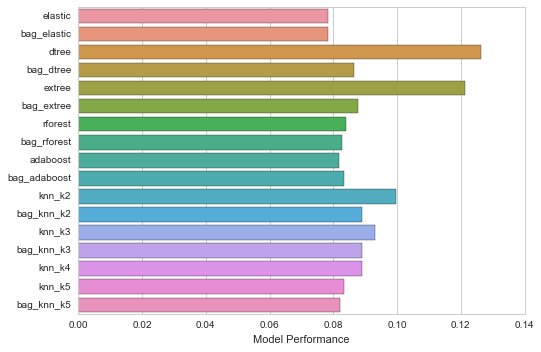

In [143]:
sb.set(style="whitegrid")
sb.barplot(x=scoring_df.T.score[:17], y=scoring_df.T.index[:17])
plt.xlabel('Model Performance')
plt.show()

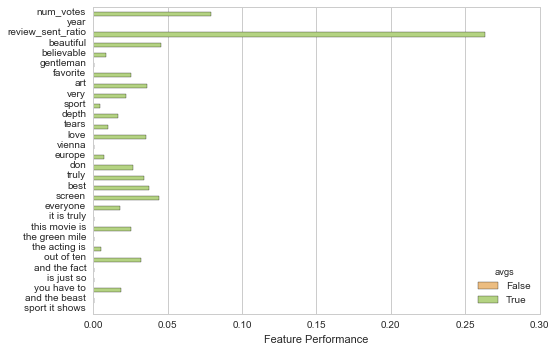

In [144]:
sb.set(style="whitegrid")
sb.barplot(x=scoring_df.avgs[2:], y=scoring_df.index[2:], palette='RdYlGn', hue=scoring_df.avgs[2:] > 0)
plt.xlabel('Feature Performance')
plt.show()

Stage 2: Prune and Re-run Models

In [145]:
#Original X
X_original = movie_revs.drop(labels=['rating',
                                     'year',
                                     'gentleman',
                                     'favorite',
                                     'sport',
                                     'vienna',
                                     'europe',
                                     'it is truly',
                                     'the green mile',
                                     'the acting is',
                                     'and the fact',
                                     'is just so',
                                     'and the beast',
                                     'sport it shows',
                                     'believable',
                                     'depth',
                                     'tears',
                                     'very',
                                     'you have to'
                                    ], 
                                     axis=1)
columns = X_original.columns

#Scalled X
scaler = StandardScaler()
X_scalled = scaler.fit_transform(X_original)

#Select the X and y
X = X_scalled
y = movie_revs.rating


list_of_models = [elastic,
                  bag_elastic,
                  dtree,
                  bag_dtree,
                  extree,
                  bag_extree,
                  rforest,
                  bag_rforest,
                  adaboost,
                  bag_adaboost,
                  knn_k2,
                  bag_knn_k2,
                  knn_k3,
                  bag_knn_k3,
                  knn_k4,
                  knn_k5,
                  bag_knn_k5,
                  knn_k6,
                  dumm]


list_of_models_str = ['elastic',
                      'bag_elastic',
                      'dtree',
                      'bag_dtree',
                      'extree',
                      'bag_extree',
                      'rforest',
                      'bag_rforest',
                      'adaboost',
                      'bag_adaboost',
                      'knn_k2',
                      'bag_knn_k2',
                      'knn_k3',
                      'bag_knn_k3',
                      'knn_k4',
                      'knn_k5',
                      'bag_knn_k5',
                      'knn_k6',
                      'dumm']

#Build index
index=[]
index.append('score')
index.append('score_std')
for x in columns:
    index.append(x) 

#Build dataframe
scoring_df = pd.DataFrame(index=index)
zipped = zip(list_of_models,list_of_models_str)

count = 0
for m in list_of_models:
    scoring_df[zipped[count][1]] = RegressorMSEScore(m, X, y, columns)
    count+=1

scoring_df['avgs'] = scoring_df.mean(axis=1)

,elastic,bag_elastic,dtree,bag_dtree,extree,bag_extree,rforest,bag_rforest,adaboost,bag_adaboost,knn_k2,bag_knn_k2,knn_k3,bag_knn_k3,knn_k4,knn_k5,bag_knn_k5,knn_k6,dumm,avgs
score,0.078477,0.0784063,0.118800,0.0857088,0.119440,0.0909428,0.084457,0.0804688,0.083771,0.0821946,0.09925,0.0870451,0.0925244,0.0870451,0.0860975,0.0839152,0.0831586,0.0824933,0.0784767,0.096989
score_std,0.087495,0.0880103,0.063799,0.0761856,0.073897,0.0740704,0.077163,0.0809298,0.075469,0.0783337,0.0671559,0.0728575,0.0694394,0.0728575,0.072023,0.0751817,0.0779195,0.0772441,0.0874951,0.075564
num_votes,0.000000,None,0.067610,None,0.067610,None,0.071458,None,0.196474,None,None,None,None,None,None,None,None,None,None,0.080630
review_sent_ratio,0.000000,None,0.572471,None,0.371151,None,0.464128,None,0.371002,None,None,None,None,None,None,None,None,None,None,0.355750
beautiful,-0.000000,None,0.064846,None,0.063740,None,0.060938,None,0.039579,None,None,None,None,None,None,None,None,None,None,0.045821
art,-0.000000,None,0.033465,None,0.072581,None,0.040734,None,0.078379,None,None,None,None,None,None,None,None,None,None,0.045032
love,-0.000000,None,0.027615,None,0.031212,None,0.043860,None,0.058299,None,None,None,None,None,None,None,None,None,None,0.032197
don,-0.000000,None,0.042716,None,0.048532,None,0.046595,None,0.029847,None,None,None,None,None,None,None,None,None,None,0.033538
truly,0.000000,None,0.039004,None,0.039420,None,0.068668,None,0.034942,None,None,None,None,None,None,None,None,None,None,0.036407
best,0.000000,None,0.063290,None,0.093104,None,0.059989,None,0.041888,None,None,None,None,None,None,None,None,None,None,0.051654


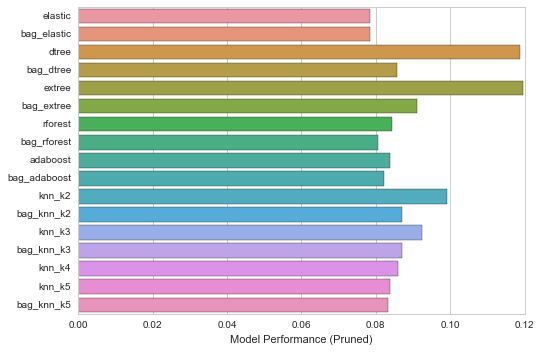

In [146]:
sb.set(style="whitegrid")
sb.barplot(x=scoring_df.T.score[:17], y=scoring_df.T.index[:17])
plt.xlabel('Model Performance (Pruned)')
plt.show()

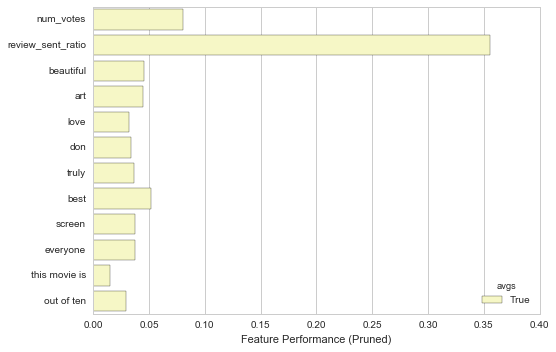

In [147]:
sb.set(style="whitegrid")
sb.barplot(x=scoring_df.avgs[2:], y=scoring_df.index[2:], palette='RdYlGn', hue=scoring_df.avgs[2:] > 0)
plt.xlabel('Feature Performance (Pruned)')
plt.show()

Stage 3: Gridsearch Top 3 Models

In [148]:
from sklearn.grid_search import GridSearchCV

In [161]:
dtree_params = {'splitter': ['best', 'random'],
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth': [2,4,6,8,10],
                'random_state': [42]
               }

gridsearch = GridSearchCV(dtree,dtree_params,cv=5)
gridsearch.fit(X,y)

dtree_gs = gridsearch.best_estimator_
gridsearch.best_params_

{'max_depth': 2,
 'max_features': 'sqrt',
 'random_state': 42,
 'splitter': 'best'}

In [162]:
extree_params = {#'n_estimators': [10, 15, 20],
                 #'criterion': ['mse','mae'],
                 'max_features': ['auto', 'sqrt', 'log2'],
                 'max_depth': [2,4,6,8,10],
                 'random_state': [42]
                }

gridsearch = GridSearchCV(extree,extree_params,cv=5)
gridsearch.fit(X,y)

extree_gs = gridsearch.best_estimator_
gridsearch.best_params_

{'max_depth': 2, 'max_features': 'sqrt', 'random_state': 42}

In [165]:
knn_k2_params = {'weights': ['uniform', 'distance'], 
                 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute', 'auto'], 
                 'leaf_size': [20, 30, 40], 
                 'p': [1,2,3],
                }

gridsearch = GridSearchCV(knn_k2,knn_k2_params,cv=5)
gridsearch.fit(X,y)

knn_k2_gs = gridsearch.best_estimator_
gridsearch.best_params_

{'algorithm': 'auto', 'leaf_size': 20, 'p': 1, 'weights': 'uniform'}

In [201]:
#Original X
X_original = movie_revs.drop(labels=['rating',
                                     'year',
                                     'gentleman',
                                     'favorite',
                                     'sport',
                                     'vienna',
                                     'europe',
                                     'it is truly',
                                     'the green mile',
                                     'the acting is',
                                     'and the fact',
                                     'is just so',
                                     'and the beast',
                                     'sport it shows',
                                     'believable',
                                     'depth',
                                     'tears',
                                     'very',
                                     'you have to',
                                     'beautiful',
                                     'this movie is',
                                     'art',
                                     'love',
                                     'don',
                                     'everyone',
                                     'truly',
                                     'best',
                                     'screen',
                                     'out of ten'
                                    ], 
                                     axis=1)
columns = X_original.columns

#Scalled X
scaler = StandardScaler()
X_scalled = scaler.fit_transform(X_original)

#Select the X and y
X = X_scalled
y = movie_revs.rating


list_of_models = [elastic,
                  bag_elastic,
                  dtree,
                  dtree_gs,
                  bag_dtree,
                  extree,
                  extree_gs,
                  bag_extree,
                  rforest,
                  bag_rforest,
                  adaboost,
                  bag_adaboost,
                  knn_k2,
                  knn_k2_gs,
                  bag_knn_k2,
                  knn_k3,
                  bag_knn_k3,
                  knn_k4,
                  knn_k5,
                  bag_knn_k5,
                  knn_k6,
                  dumm]


list_of_models_str = ['elastic',
                      'bag_elastic',
                      'dtree',
                      'dtree_gs',
                      'bag_dtree',
                      'extree',
                      'extree_gs',
                      'bag_extree',
                      'rforest',
                      'bag_rforest',
                      'adaboost',
                      'bag_adaboost',
                      'knn_k2',
                      'knn_k2_gs',
                      'bag_knn_k2',
                      'knn_k3',
                      'bag_knn_k3',
                      'knn_k4',
                      'knn_k5',
                      'bag_knn_k5',
                      'knn_k6',
                      'dumm']

#Build index
index=[]
index.append('score')
index.append('score_std')
for x in columns:
    index.append(x) 

#Build dataframe
scoring_df = pd.DataFrame(index=index)
zipped = zip(list_of_models,list_of_models_str)

count = 0
for m in list_of_models:
    scoring_df[zipped[count][1]] = RegressorMSEScore(m, X, y, columns)
    count+=1

scoring_df['avgs'] = scoring_df.mean(axis=1)

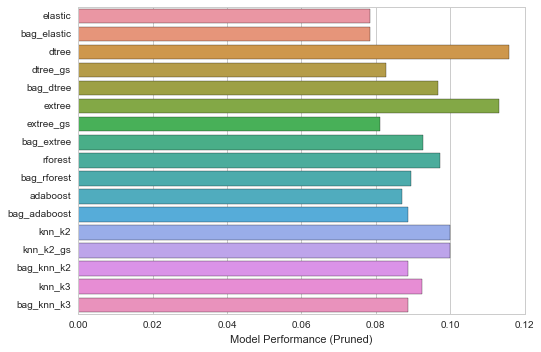

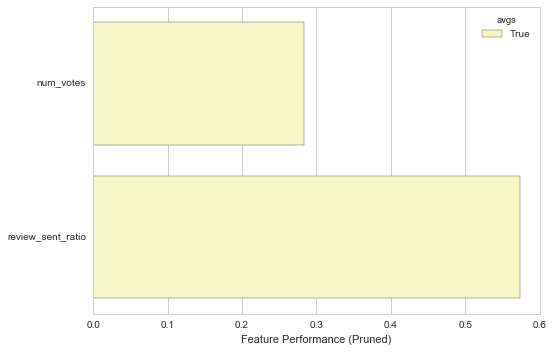

In [202]:
sb.set(style="whitegrid")
sb.barplot(x=scoring_df.T.score[:17], y=scoring_df.T.index[:17])
plt.xlabel('Model Performance (Pruned)')
plt.show()

sb.set(style="whitegrid")
sb.barplot(x=scoring_df.avgs[2:], y=scoring_df.index[2:], palette='RdYlGn', hue=scoring_df.avgs[2:] > 0)
plt.xlabel('Feature Performance (Pruned)')
plt.show()

Stage 4: Validate Models

In [203]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [205]:
dtree.fit(X_train, y_train)
dtree_prediction =  dtree.predict(X_test)
r2_score(y_test, dtree_prediction)

-0.90293895488566989

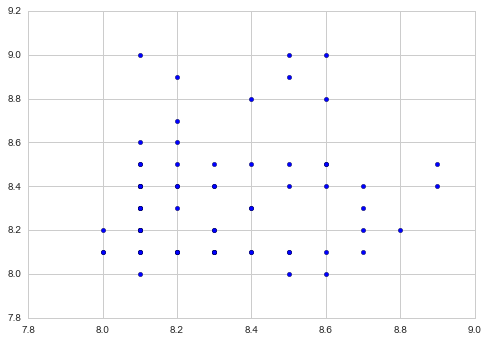

In [206]:
plt.scatter(y_test, dtree_prediction)
plt.show()

In [207]:
extree.fit(X_train, y_train)
extree_prediction = extree.predict(X_test)
r2_score(y_test, extree_prediction)

-0.87976378493442353

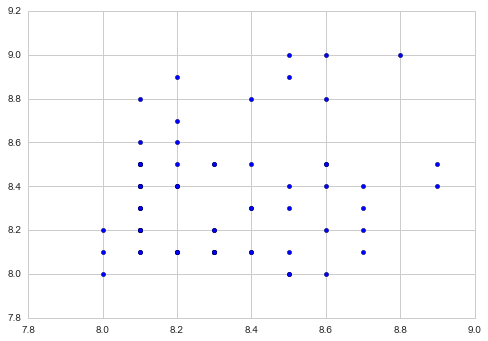

In [208]:
plt.scatter(y_test, extree_prediction)
plt.show()

In [209]:
knn_k2.fit(X_train, y_train)
knn_k2_prediction = knn_k2.predict(X_test)
r2_score(y_test, knn_k2_prediction)

-0.17613987502574946

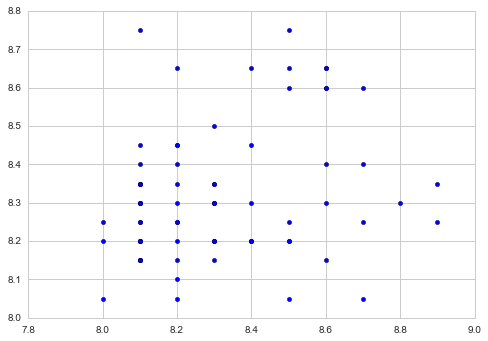

In [210]:
plt.scatter(y_test, knn_k2_prediction)
plt.show()

# Possible Next Steps

* Use Hyperplot instead of Gridsearch
* Do some PCA analysis
* Do a cluster analysis using one of the clustering methods we've covered
* Evaluate solely based on quality metrics such as SSE/inertia and sillhouette or others
* Describe your findings based on the predicted clusters (How well did it do? What's good or bad? How would you improve this? Does any of it make sense?)
